In [5]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import re
import collections
import packages.helpers as hlp

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import pymc as pm

names = ['Kris Kroski', 'Eddie VanBogaert', 'Boaz Reisman', 'Brad Siefert', 
         'Kyle Gilbert', 'Richard Hankison', 'Vladimir Jornitski', 'Rachel Schneebaum',
        'Frank Korf', 'Andrew Parnell']

months = {
    'Jan':0,
    'Feb':31,
    'Mar':59,
    'Apr':90,
    'May':120,
    'Jun':151,
    'Jul':181,
    'Aug':212,
    'Sep':243,
    'Oct':273,
    'Nov':304, 
    'Dec':334
}

room_strs = ['joined the room', 'left the room']
docs = collections.defaultdict(list)
day_index = 0
index = 0
dates = {}
date_str = ""

with open('data/hipchat_room','r') as f:
    for line in f:
        if any(name in line for name in names) and not any(room_str in line for room_str in room_strs):        
            try:
                mon, day = re.sub(r'^(.*?)\xc2\xb7', '', line).split(' ')[0].split('-')
            except:
                continue

            if mon and day:                
                day_index = months[mon] + int(day)
                #new_date_str = "{} {}".format(mon, day)
                #if new_date_str != date_str:
                #    date_str = new_date_str
                #    index += 1
                #    dates[index] = date_str
                #print(mon, day, day_index)
        elif not any(room_str in line for room_str in room_strs) and ', 201' not in line:
            #print "{} -- {}".format(day_index, line)
            docs[day_index].append(hlp.prettify(line))
            
    

#print dates
#print len(docs)
indexes = docs.keys()

chat_count = [len(docs[i]) for i in range(indexes[0], indexes[len(indexes) - 1])]

print chat_count


[7, 0, 0, 0, 0, 15, 15, 0, 0, 1, 10, 25, 1, 1, 0, 0, 0, 3, 2, 7, 4, 0, 0, 0, 16, 1, 6, 1, 0, 0, 2, 7, 15, 61, 2, 2, 0, 0, 10, 0, 11, 5, 2, 0, 0, 24, 5, 2, 3, 11, 0, 0, 3, 11, 2, 24, 0, 0, 0, 6, 21, 13, 0, 2, 0, 0, 1, 11, 0, 4, 14, 0, 0, 15, 8, 18, 3, 13, 2, 0, 4, 6, 0, 8, 8, 0, 0, 9, 5, 7, 0, 1, 0, 0, 20, 11, 1, 8, 5, 0, 0, 4, 3, 21, 5, 18, 0, 0, 11, 5, 4, 11, 0, 0, 0, 3, 12, 1, 8, 0, 0, 0, 5, 24, 23, 2, 1, 0, 0, 5, 7, 8, 2, 14, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 5, 1, 5, 0, 8, 0, 0, 8, 0, 11, 11, 5, 0, 0, 8, 0, 0, 6, 1, 0, 0, 0, 1, 2, 0, 4, 0, 0, 1, 0, 1, 4, 0, 0, 0, 24, 7, 11, 0, 35, 0, 0, 10, 1, 0, 0, 21, 0, 0, 17, 38, 6, 3, 11, 1, 1, 1, 0, 15, 5, 10, 0, 0, 8, 1, 2, 14, 0, 0, 2, 12, 9, 32, 11, 21, 0, 0, 6, 15, 3, 3, 29, 0, 0, 7, 33, 4, 1, 2, 0, 0, 16, 3, 0, 16, 24, 0, 0, 0, 1, 42, 3, 2, 0, 0, 50, 13, 7, 0, 2, 0, 0, 11, 0, 3, 9, 7, 0, 0, 4, 24, 0, 4, 11, 0, 0, 12, 5, 11, 7, 33, 0, 0, 14, 2, 16, 16, 3, 0, 3, 28, 8, 32, 10, 7, 0, 4, 13, 41, 58, 8, 6, 0, 0, 8, 12, 0, 6, 5, 

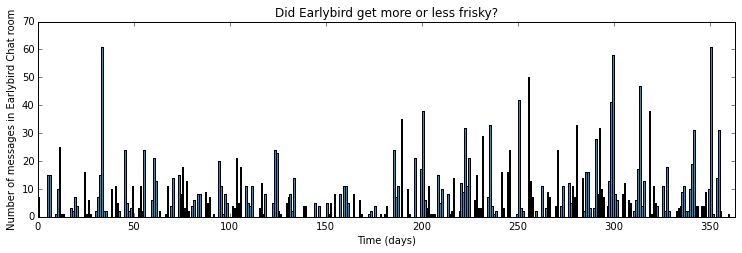

In [7]:
figsize(12.5, 3.5)

count_data = np.array(chat_count)
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Number of messages in Earlybird Chat room")
plt.title("Did Earlybird get more or less frisky?")
plt.xlim(0, n_count_data);

In [11]:
alpha = 1.0 / count_data.mean()  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)


#print "Random output:", tau.random(), lambda_1.random(), lambda_2.random()

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out


observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 10.9 sec

In [12]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

{}


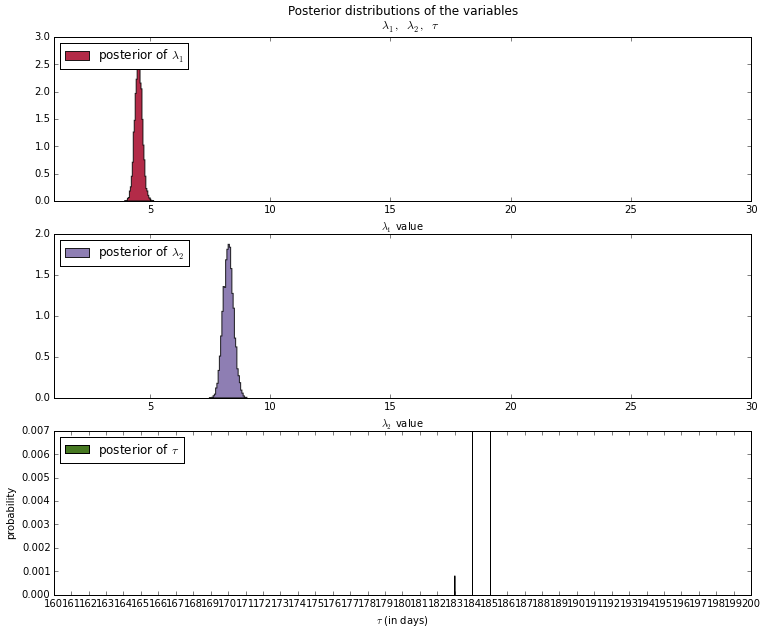

In [19]:
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(True)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([1, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(True)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([1, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .007])
#plt.xlim([35, len(count_data) - 20])
plt.xlim([160, 200])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");


['Me every day\n', 'toesalad.com/media/images/article/lego-treadmill-desk.jpg\n', 'Image\n', 'And I want this\n', 'https://annporter.files.wordpress.com/2014/07/standing-lego-minifig-as-cable-holder-kitchann.jpg\n', 'Image\n', 'www.buzzfeed.com/craigsilverman/please-let-them-watch-something-else\n', 'In later seasons, stories are introduced by his cat (in puppet form for some reason), who apparently can talk, but only in puppet form. In the story that the cat has introduced, the not-grandmother is still narrating, and the cat is now Caillou\xe2\x80\x99s not-special, not-talking, not-puppet cat. I don\xe2\x80\x99t get it at all.\n', 'https://31.media.tumblr.com/1a8211874774c765a97c5bd278b1bf74/tumblr_inline_n7dnnvujC61ru8le0.gif\n', 'Image\n', 'I have so much hate in my heart for Caillou\n']


In [20]:
# This: http://fjavieralba.com/basic-sentiment-analysis-with-python.html

import sentiment.dumbSentiment as ds

sentiment = ds.dumbSentiment()

for x in docs:
    line_list = docs[x]
    print x
    for line in line_list:
        print line
        print sentiment.get_sentiment(line)


2
Hey guys I'm gonna take today off. My brain is fried and I need a mental health day! Hope everyone had a great NYE

0.980580675691
I don't think that I have anything due today.

0.0
@all Starting at 5pm I will be screensharing a demo, so please do not hipchat me or send me messages during that time

0.2
i will try to only share the window im demoing

0.301511344578
but just to be on the safe side

0.333333333333
Henry Vasquez·Jan-5 5:20 PM

0.0
EB devs: y'all should look into the Chicago Laravel Group and maybe go to their next event. good way to meet people, and find our next developer! www.meetup.com/laravel-chicago/

0.514495755428
3
4
5
6
7
might be late to standups tomorrow morning boys

0.0
standups in t-minus 37 seconds

0.0
@KrisKroski @BradSiefert prayer app call got moved to 3 fun

1.15470053838
Fyi

0.0
*

0.0
Cool. I'll have something to you by before then

0.301511344578
*hits the corners in the lo los, girl*

0.0
...

0.0
dont worry andrew, i still got love for the stre